In [5]:
import logging
import mmap
import h5py
import torch
from torch.utils.data import Dataset
import numpy as np
import os

In [6]:
logger = logging.getLogger(__name__)

In [7]:
def compute_seq_id(hit, or_id=0):
    disk_id, pm_id, sc_id, up_dw_id, _ = hit
    """Compute the RICH PMT sequence ID"""
    if or_id < 1:
        seq_id = sc_id * 8 + pm_id + up_dw_id * 61 * 8 + disk_id * 61 * 8 * 2
    else:
        seq_id = 61 * 8 * 2 * 2 + sc_id + up_dw_id * 61 + disk_id * 61 * 2
    return int(seq_id)

compute_seq_id = np.vectorize(compute_seq_id)

In [170]:
# Original Author: Bob
# Modified by: Rakesh Pandey

class RICHDataset(Dataset):
    """RICH pytorch dataset."""

    def check_dataset(self, name, obj):
        """ "Check the input file fromat."""
        if isinstance(obj, h5py.Dataset):
            print(name, obj.shape)
            print(name, obj.chunks)
            print(name, obj.compression)
            print(name, obj.dtype)
            # raise BadDataFormat('Unexpected data format, check the logs.')

    def __init__(
        self, dset_path, val_split, test_split, return_type="tensor", seed=None
    ):

        self.return_type = return_type

        if seed:
            np.random.seed(seed)

        # We don't attempt to catch exception here, crash if we cannot open the file.
        with h5py.File(dset_path, "r") as dfile:

            for key in dfile.attrs:
                logger.info("%s: %s", key, dfile.attrs[key])

            # We don't attempt to catch exception here,
            # crash if the data format is not what we were expecting.
            dfile.visititems(self.check_dataset)

            # Load the hit map into memory
            self.hit_mapping = np.asarray(dfile["HitMapping"][:])
            logger.info("hit map size: %i bytes", self.hit_mapping.nbytes)
            self.N = len(self.hit_mapping) - 1  # !!! The last cell is the sentinel !!!

            # Get the info we need to memory map the hits
            hit_ds = dfile["Hits"]
            hit_offset = hit_ds.id.get_offset()
            hit_dtype = hit_ds.dtype
            hit_shape = hit_ds.shape
            hit_length = np.prod(hit_shape)
            # Get the info we need to memory map the events
            event_ds = dfile["Events"]
            event_offset = event_ds.id.get_offset()
            event_dtype = event_ds.dtype
            event_shape = event_ds.shape
            event_length = np.prod(event_shape)

            # train test indices
            indices = np.arange(len(self))
            n_val = int(len(indices) * val_split)
            n_test = int(len(indices) * test_split)
            self.train_indices = indices[: -n_val - n_test]
            self.val_indices = indices[-n_test - n_val : -n_test]
            self.test_indices = indices[-n_test:]

        # We don't attempt to catch exception here, crash if we cannot open the file.
        with open(dset_path, "rb") as fh:
            fileno = fh.fileno()
            mapping = mmap.mmap(fileno, 0, access=mmap.ACCESS_READ)
            self.hit_array = np.frombuffer(
                mapping, dtype=hit_dtype, count=hit_length, offset=hit_offset
            ).reshape(hit_shape)
            logger.info("hit array mmap size: %i bytes", self.hit_array.nbytes)
            self.event_array = np.frombuffer(
                mapping, dtype=event_dtype, count=event_length, offset=event_offset
            ).reshape(event_shape)
            logger.info("event array mmap size: %i bytes", self.event_array.nbytes)

    def get_position_data(self):
        return np.load(os.path.join("tools", "rich_pmt_positions.npy"))

    def get_event_pos(self, idx):

        # get hits
        idx_from = self.hit_mapping[idx]
        idx_to = self.hit_mapping[idx + 1]
        hits = self.hit_array[idx_from:idx_to]

        # load position map data
        position_map = self.get_position_data()

        # create index
        index = compute_seq_id(hits)
        event_pos = position_map[index]

        return event_pos

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        if not isinstance(idx, int):
            raise NotImplementedError(f"{type(idx)} type key access is not implemented")
        if idx < 0:
            raise NotImplementedError("negative index access is not implemented")

        idx_from = self.hit_mapping[idx]
        idx_to = self.hit_mapping[idx + 1]

        # prepare data
        event_pos = self.get_event_pos(idx)
        # labels = self.event_array[idx]["labels"]
        hit_time = self.hit_array[idx_from:idx_to]["hit_time"]
        chod_time = self.event_array[idx]["chod_time"]
        track_momentum = self.event_array[idx]["track_momentum"]
        ring_radius = self.event_array[idx]["ring_radius"]

        if self.return_type == "numpy":
            return {
                "event_pos": event_pos,
                # "lablel": labels,
                "hit_time": hit_time,
                "chod_time": chod_time,
                "track_momentum": track_momentum,
                "ring_radius": ring_radius,
            }
        elif self.return_type == "tensor":
            return {
                "event_pos": torch.tensor(event_pos),
                # "lablel":labels,
                "hit_time": torch.tensor(hit_time),
                "chod_time": torch.tensor(chod_time),
                "track_momentum": torch.tensor(track_momentum),
                "ring_radius": torch.tensor(ring_radius),
            }

In [171]:
dset = RICHDataset("/data/bvelghe/capstone2022/A/Run008548.EOSlist.CTRL.p.v2.0.4-01_f.v2.0.4-01.h5", val_split=0.1, test_split=0.1, return_type="tensor")

Events (128982,)
Events None
Events None
Events {'names': ['run_id', 'burst_id', 'event_id', 'track_id', 'track_momentum', 'chod_time', 'ring_radius', 'ring_centre_pos', 'ring_likelihood'], 'formats': ['<i4', '<i4', '<i8', '<i4', '<f4', '<f4', '<f4', ('<f4', (2,)), ('<f4', (3,))], 'offsets': [0, 4, 8, 16, 20, 24, 28, 32, 40], 'itemsize': 56}
HitMapping (128983,)
HitMapping (128982,)
HitMapping gzip
HitMapping int64
Hits (4689741,)
Hits None
Hits None
Hits [('disk_id', '<i4'), ('pmt_id', '<i4'), ('supercell_id', '<i4'), ('updowndisk_id', '<i4'), ('hit_time', '<f4')]


In [172]:
print(dset[0])
print(dset[len(dset)-1])
print(len(dset))

{'event_pos': tensor([[-171.0000,  -93.5300,    1.0000],
        [   0.0000, -171.4700,    1.0000],
        [ -27.0000, -187.0600,    1.0000],
        [-153.0000,   93.5300,    1.0000],
        [-162.0000,   77.9400,    1.0000],
        [-171.0000,   62.3500,    1.0000],
        [ -72.0000,  171.4700,    1.0000],
        [ 189.0000,  -31.1800,    1.0000],
        [ 180.0000,   46.7700,    1.0000],
        [ 180.0000,   15.5900,    1.0000],
        [ 180.0000,  -46.7700,    1.0000],
        [ 162.0000,   77.9400,    1.0000],
        [-171.0000,  -62.3500,    1.0000],
        [-198.0000,  -77.9400,    1.0000],
        [-207.0000, -124.7100,    1.0000],
        [-108.0000,  140.3000,    1.0000],
        [ 189.0000,  -62.3500,    1.0000],
        [ 162.0000,   46.7700,    1.0000],
        [ 153.0000,    0.0000,    1.0000],
        [ 144.0000,  -46.7700,    1.0000],
        [-171.0000,   62.3500,    1.0000],
        [ -27.0000, -187.0600,    1.0000]]), 'hit_time': tensor([  6.4918,   6.3340

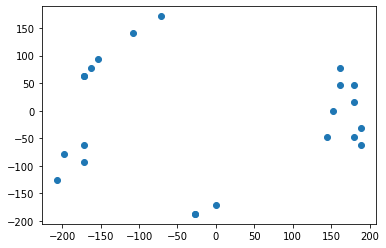

In [173]:
import matplotlib.pyplot as plt
plt.scatter(dset[0]["event_pos"][:,0], dset[0]["event_pos"][:,1])
plt.show()

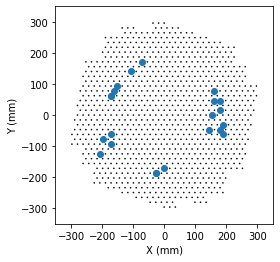

In [174]:
from event_display.plot_event import draw_pmt_pos
fig = plt.figure()
ax = fig.subplots()
ax.set_aspect('equal')
ax.set_xlim(-350,350) # mm
ax.set_ylim(-350,350) # mm
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
draw_pmt_pos(ax, dset.get_position_data())
plt.scatter(dset[0]["event_pos"][:,0], dset[0]["event_pos"][:,1])
plt.show()

In [176]:
dset.train_indices

array([     0,      1,      2, ..., 103183, 103184, 103185])

In [177]:
dset.event_array

array([(8548, 1095,   11551, 0, 39.102062,  6.377106 , 184.68147, [-196.52412  ,  -16.790398 ], [5.2108949e-01, 1.0000000e+00, 3.3442233e-05]),
       (8548, 1095,   62102, 0, 43.845306,  6.220097 , 184.9323 , [   6.3917556,  -24.476423 ], [1.5753073e-01, 1.0000000e+00, 1.9092786e-01]),
       (8548, 1095,   66328, 0, 49.434795,  4.1999097, 189.74113, [ -78.32746  ,  -71.59249  ], [1.6594762e-01, 9.1073775e-01, 1.0000000e+00]),
       ...,
       (8548,    8,  687077, 0, 35.895885,  4.063919 , 189.60388, [-115.83869  ,  -37.7422   ], [6.1766016e-19, 4.8908441e-06, 1.0000000e+00]),
       (8548,    8, 1116864, 0, 24.034994, 20.309193 , 192.61932, [-114.256775 ,   83.53365  ], [1.2160993e-37, 1.5893112e-17, 1.0000000e+00]),
       (8548,    9,  945834, 0, 29.24393 , 18.262516 , 189.4073 , [-205.64192  ,    9.161364 ], [3.7009421e-27, 1.6712754e-08, 1.0000000e+00])],
      dtype={'names': ['run_id', 'burst_id', 'event_id', 'track_id', 'track_momentum', 'chod_time', 'ring_radius', 'ring_ce

In [179]:
# train validation and test
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

train_iter = DataLoader(
    dset,
    batch_size=64,
    shuffle=False,
    sampler=SubsetRandomSampler(dset.train_indices),
    num_workers=4,
)
val_iter = DataLoader(
    dset,
    batch_size=64,
    shuffle=False,
    sampler=SubsetRandomSampler(dset.val_indices),
    num_workers=4,
)
test_iter = DataLoader(
    dset,
    batch_size=64,
    shuffle=False,
    sampler=SubsetRandomSampler(dset.test_indices),
    num_workers=4,
)


In [169]:
for i_batch, batch_data in enumerate(val_iter):
    print(batch_data.shape)

NotImplementedError: Caught NotImplementedError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_25313/1456706082.py", line 98, in __getitem__
    raise NotImplementedError(f"{type(idx)} type key access is not implemented")
NotImplementedError: <class 'numpy.int64'> type key access is not implemented


--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
    await self.process_one()
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
    await dispatch(*args)
TypeError: object NoneType can't be used in 'await' expression

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1089, in emit
    self.flush()
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1069, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.8/site-packages/ipykernel_launch

In [ ]:
next_batch[0]

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
    await self.process_one()
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
    await dispatch(*args)
TypeError: object NoneType can't be used in 'await' expression

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1089, in emit
    self.flush()
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1069, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.8/site-packages/ipykernel_launch